In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import jax
jax.config.update("jax_enable_x64", True)

In [3]:
import jax
import jax.numpy as jnp
import numpy as nnp
import os
import sys
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

from core.optimiser import Optimiser, RiemannSGDOptimiser
from core.cost import cost_function
from core.utils import imu_preprocessing, read_data, vicon_processing, get_eulers_from_quaternions, generate_panaroma
from core.model import euler_integration

In [12]:
folder_path = "./"

set_name = "trainset"
trainset_path = os.path.join(folder_path, "data/{}".format(set_name))
imu_path = os.path.join(trainset_path, "imu")
cam_path = os.path.join(trainset_path, "cam")
vicon_path = os.path.join(trainset_path, "vicon")

In [13]:
imu_file_name = 'imuRaw1.p'

file_number = imu_file_name.split("imuRaw")[1].split(".")[0]
vicon_file_name = "viconRot{}.p".format(file_number)

In [14]:
result_path = os.path.join(folder_path, "results/{}_{}".format(set_name, file_number))
if not os.path.exists(result_path):
    os.makedirs(result_path)

In [15]:
print(imu_file_name, vicon_file_name)

imu_file_path = os.path.join(imu_path, imu_file_name)
vicon_file_path = os.path.join(vicon_path, vicon_file_name)
cam_file_path = os.path.join(cam_path, "cam" + file_number + ".p")

imu_vals, imu_ts = imu_preprocessing(imu_file_path)
vicon_eulers, vicon_ts = vicon_processing(vicon_file_path)

qs = euler_integration(imu_vals, imu_ts)

imuRaw1.p viconRot1.p


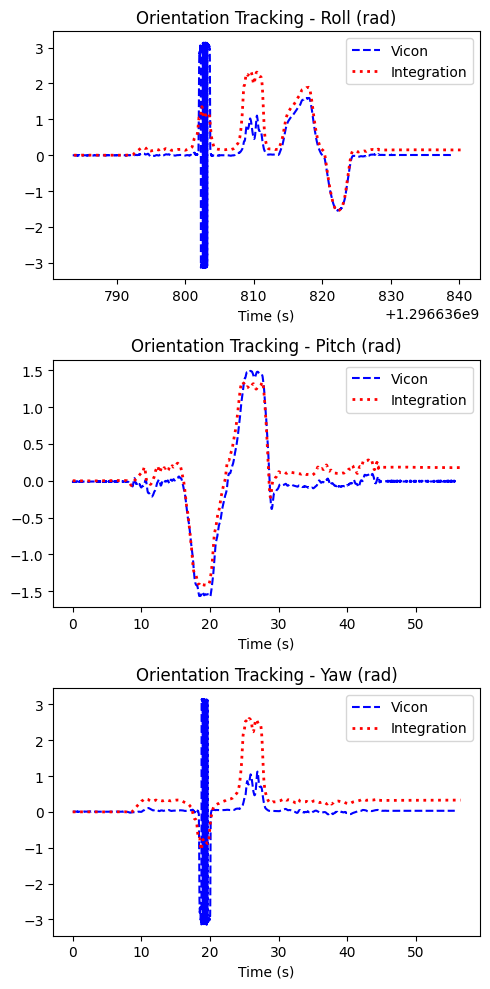

In [44]:
euler_from_qs = get_eulers_from_quaternions(qs)

fig, axs = plt.subplots(3, 1, figsize=(5, 10))

# plot the first column
axs[0].plot(vicon_ts, vicon_eulers[:, 0], label="Vicon", color = "blue", linestyle = "dashed")
axs[0].plot(imu_ts, euler_from_qs[:, 0], label="Integration", color = "red", linestyle = "dotted", linewidth = 2)
axs[0].set_xlabel('Time (s)')
axs[0].title.set_text("Orientation Tracking - Roll (rad)")
axs[0].legend()

# plot the second column
axs[1].plot(vicon_ts - vicon_ts[0], vicon_eulers[:, 1], label="Vicon", color = "blue", linestyle = "dashed")
axs[1].plot(imu_ts - imu_ts[0], euler_from_qs[:, 1], label="Integration", color = "red", linestyle = "dotted", linewidth = 2)
axs[1].set_xlabel('Time (s)')
axs[1].title.set_text("Orientation Tracking - Pitch (rad)")
axs[1].legend()

# plot the third column
axs[2].plot(vicon_ts - vicon_ts[0], vicon_eulers[:, 2], label="Vicon", color = "blue", linestyle = "dashed")
axs[2].plot(imu_ts - imu_ts[0], euler_from_qs[:, 2], label="Integration", color = "red", linestyle = "dotted", linewidth = 2)
axs[2].set_xlabel('Time (s)')
axs[2].title.set_text("Orientation Tracking - Yaw (rad)")
axs[2].legend()

# very tight layout and save the figure
plt.tight_layout()
plt.savefig("{}/orientation_tracking.png".format(result_path))
plt.show()

In [45]:
q = qs.copy()

optimiser = RiemannSGDOptimiser(q, imu_vals, imu_ts, learning_rate=0.01)

iter_num = 0

logs = {
    "cost": [],
    "cost_motion": [],
    "cost_observation": [],
}

# while(iter_num < 50 or ep):
for i in range(5):
    optimiser.update()
    optimiser.project()
    q = optimiser.params
    cost, (cost_logs) = optimiser.cost, optimiser.cost_logs
    cost_motion, cost_observation = cost_logs["cost_motion"]/1000000000.0, cost_logs["cost_observation"]/10000.0
    print("iter: {}, cost: {:.4f}, cost_motion: {:.4f}, cost_observation: {:.4f}".format(i, cost, cost_motion, cost_observation))
    logs["cost"].append(cost)
    logs["cost_motion"].append(cost_motion)
    logs["cost_observation"].append(cost_observation)

iter: 0, cost: 143.8583, cost_motion: 0.0009, cost_observation: 287.7157
iter: 1, cost: 133.3264, cost_motion: 0.0047, cost_observation: 266.6482
iter: 2, cost: 123.6388, cost_motion: 0.0140, cost_observation: 247.2636
iter: 3, cost: 114.7282, cost_motion: 0.0269, cost_observation: 229.4294
iter: 4, cost: 106.5326, cost_motion: 0.0419, cost_observation: 213.0233


In [104]:
# save logs to file
import pickle
with open(os.path.join(result_path, "logs.json"), "wb") as f:
    pickle.dump(logs, f)

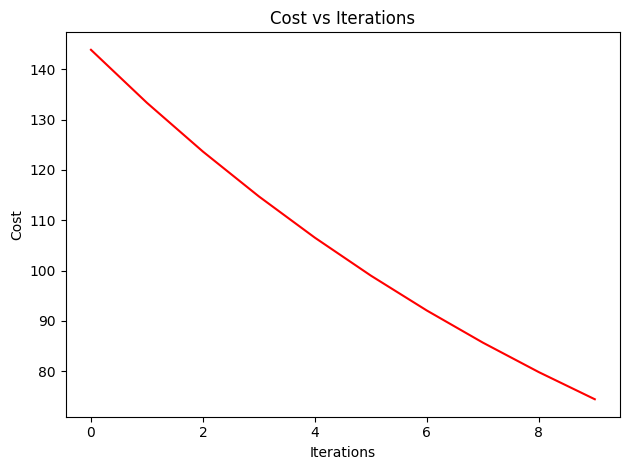

In [83]:
# plot between cost and iterations
plt.plot(logs["cost"], label="Cost", color = "red")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost vs Iterations")
plt.tight_layout()
plt.savefig(os.path.join(result_path, "cost_vs_iterations.png"))

In [9]:
euler_from_q = get_eulers_from_quaternions(q)
euler_from_qs = get_eulers_from_quaternions(qs)

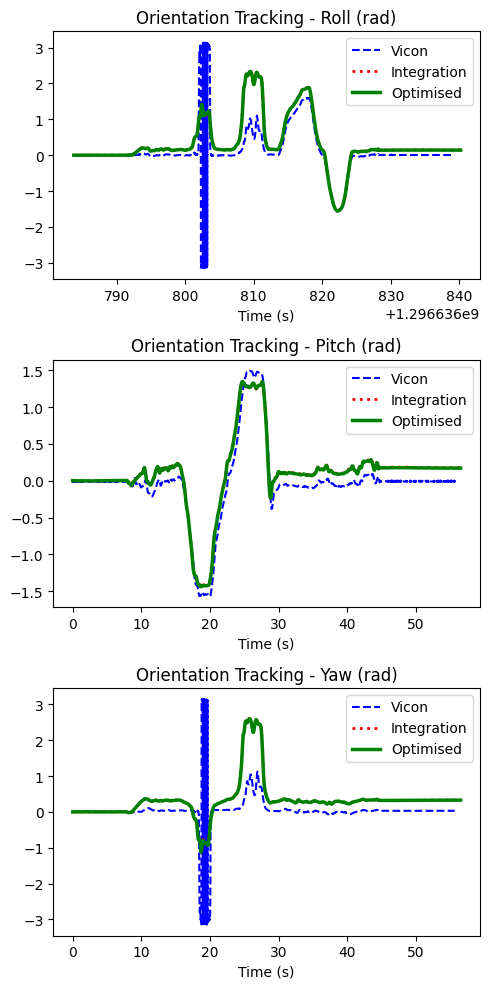

In [13]:
fig, axs = plt.subplots(3, 1, figsize=(5, 10))

# plot the first column
axs[0].plot(vicon_ts, vicon_eulers[:, 0], label="Vicon", color = "blue", linestyle = "dashed")
axs[0].plot(imu_ts, euler_from_qs[:, 0], label="Integration", color = "red", linestyle = "dotted", linewidth = 2)
axs[0].plot(imu_ts, euler_from_q[:, 0], label="Optimised", color = "green", linewidth = 2.5)
axs[0].set_xlabel('Time (s)')
axs[0].title.set_text("Orientation Tracking - Roll (rad)")
axs[0].legend()

# plot the second column
axs[1].plot(vicon_ts - vicon_ts[0], vicon_eulers[:, 1], label="Vicon", color = "blue", linestyle = "dashed")
axs[1].plot(imu_ts - imu_ts[0], euler_from_qs[:, 1], label="Integration", color = "red", linestyle = "dotted", linewidth = 2)
axs[1].plot(imu_ts - imu_ts[0], euler_from_q[:, 1], label="Optimised", color = "green", linewidth = 2.5)
axs[1].set_xlabel('Time (s)')
axs[1].title.set_text("Orientation Tracking - Pitch (rad)")
axs[1].legend()

# plot the third column
axs[2].plot(vicon_ts - vicon_ts[0], vicon_eulers[:, 2], label="Vicon", color = "blue", linestyle = "dashed")
axs[2].plot(imu_ts - imu_ts[0], euler_from_qs[:, 2], label="Integration", color = "red", linestyle = "dotted", linewidth = 2)
axs[2].plot(imu_ts - imu_ts[0], euler_from_q[:, 2], label="Optimised", color = "green", linewidth = 2.5)
axs[2].set_xlabel('Time (s)')
axs[2].title.set_text("Orientation Tracking - Yaw (rad)")
axs[2].legend()

# very tight layout and save the figure
plt.tight_layout()
plt.savefig("{}/orientation_tracking.png".format(result_path))
plt.show()

In [45]:
if os.path.exists(cam_file_path):
    panorama_image_optimised = generate_panaroma(cam_file_path, q, imu_ts)
    panorama_image_integration = generate_panaroma(cam_file_path, qs, imu_ts)

100%|██████████| 1685/1685 [00:23<00:00, 72.82it/s]


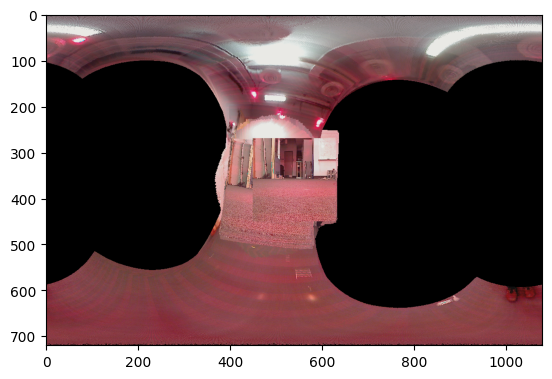

In [66]:
plt.tight_layout()
plt.imsave("{}/pan_img_optimised.png".format(result_path), panorama_image_optimised.astype(nnp.uint8))
plt.imshow(panorama_image_optimised.astype(nnp.uint8))

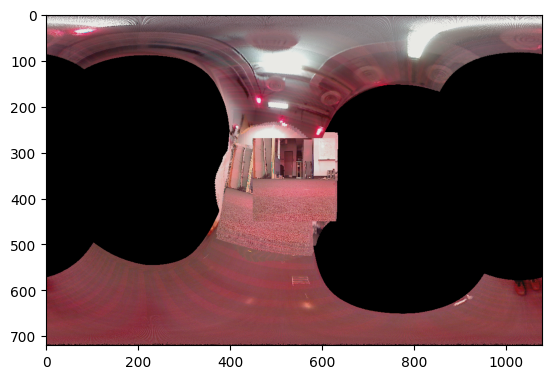

In [65]:
plt.tight_layout()
plt.imsave("{}/pan_img_integration.png".format(result_path), panorama_image_integration.astype(nnp.uint8))
plt.imshow(panorama_image_integration.astype(nnp.uint8))

In [105]:
# convert notebook to python file
!jupyter nbconvert --to script orientation_tracking.ipynb --output orientation_tracking2

[NbConvertApp] Converting notebook orientation_tracking.ipynb to script
[NbConvertApp] Writing 5282 bytes to orientation_tracking.py


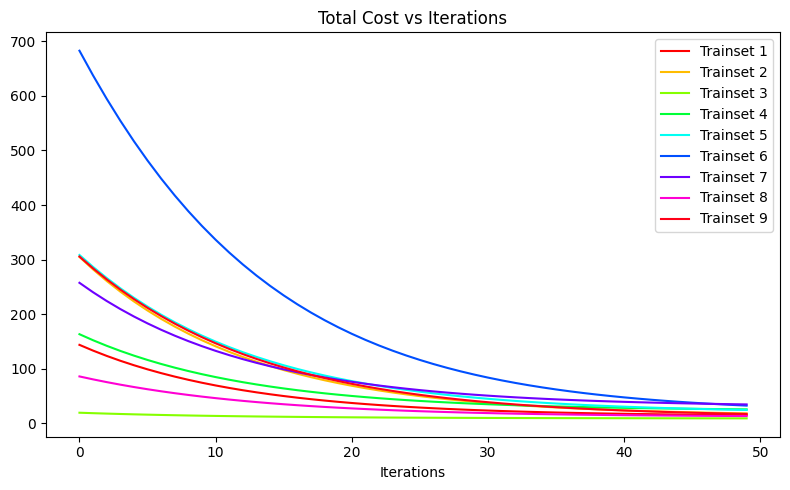

In [52]:
# gather results from all the experiments

results_folder = "results"
experiment_logs = sorted([os.path.join(results_folder, x, "logs.json") for x in os.listdir(results_folder) if x.startswith("train")])

# get the cost logs
cost_logs = []
for log_file in experiment_logs:
    with open(log_file, "rb") as f:
        cost_logs.append(pickle.load(f))
        
# plot the cost vs iterations
plt.figure(figsize=(8, 5))
cmap = plt.cm.get_cmap("hsv", len(cost_logs))
for i, cost_log in enumerate(cost_logs):
    plt.plot(cost_log["cost"], label="Trainset {}".format(i+1), color = cmap(i))

plt.xlabel("Iterations")
plt.title("Total Cost vs Iterations")
plt.legend()
plt.tight_layout()
plt.savefig("{}/cost_vs_iterations.png".format(results_folder))
plt.show()


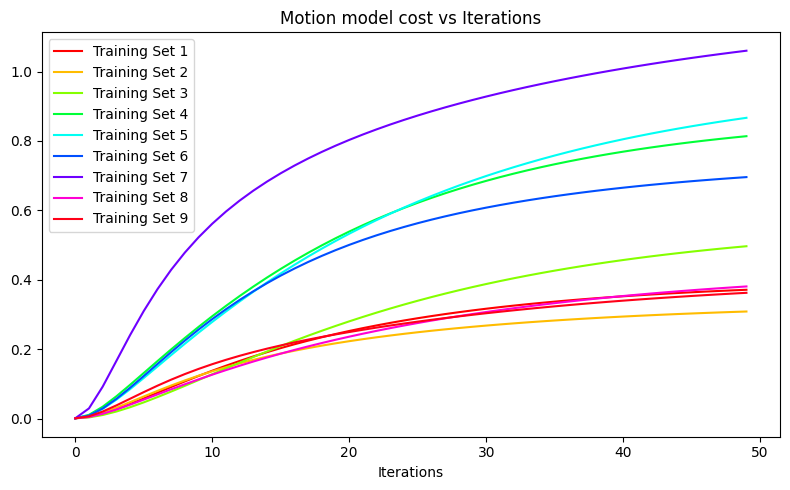

In [53]:
# gather results from all the experiments

results_folder = "results"
experiment_logs = sorted([os.path.join(results_folder, x, "logs.json") for x in os.listdir(results_folder) if x.startswith("train")])

# get the cost logs
cost_logs = []
for log_file in experiment_logs:
    with open(log_file, "rb") as f:
        cost_logs.append(pickle.load(f))
        
# plot the cost vs iterations
plt.figure(figsize=(8, 5))
cmap = plt.cm.get_cmap("hsv", len(cost_logs))
for i, cost_log in enumerate(cost_logs):
    plt.plot(cost_log["cost_motion"], label="Training Set {}".format(i+1), color = cmap(i))
plt.xlabel("Iterations")
plt.title("Motion model cost vs Iterations")
plt.legend()
plt.tight_layout()
plt.savefig("{}/motion_cost_vs_iterations.png".format(results_folder))

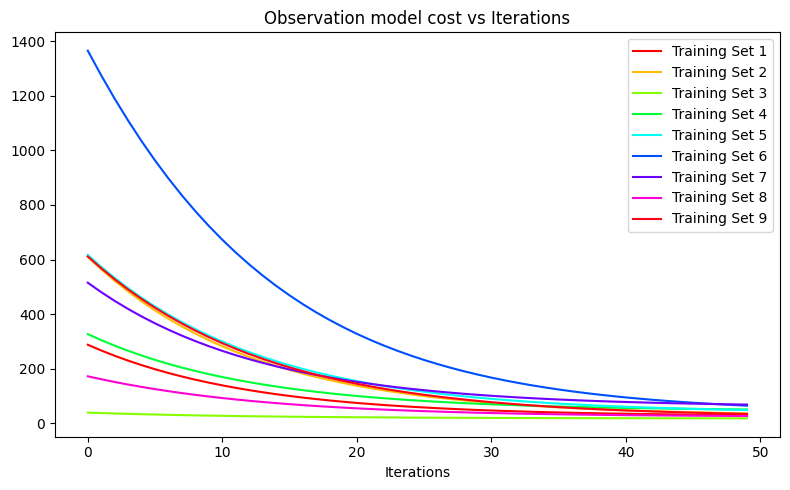

In [54]:
# gather results from all the experiments

results_folder = "results"
experiment_logs = sorted([os.path.join(results_folder, x, "logs.json") for x in os.listdir(results_folder) if x.startswith("train")])

# get the cost logs
cost_logs = []
for log_file in experiment_logs:
    with open(log_file, "rb") as f:
        cost_logs.append(pickle.load(f))
        
# plot the cost vs iterations
plt.figure(figsize=(8, 5))
cmap = plt.cm.get_cmap("hsv", len(cost_logs))
for i, cost_log in enumerate(cost_logs):
    plt.plot(cost_log["cost_observation"], label="Training Set {}".format(i+1), color = cmap(i))
plt.xlabel("Iterations")
plt.title("Observation model cost vs Iterations")
plt.legend()
plt.tight_layout()
plt.savefig("{}/observation_cost_vs_iterations.png".format(results_folder))